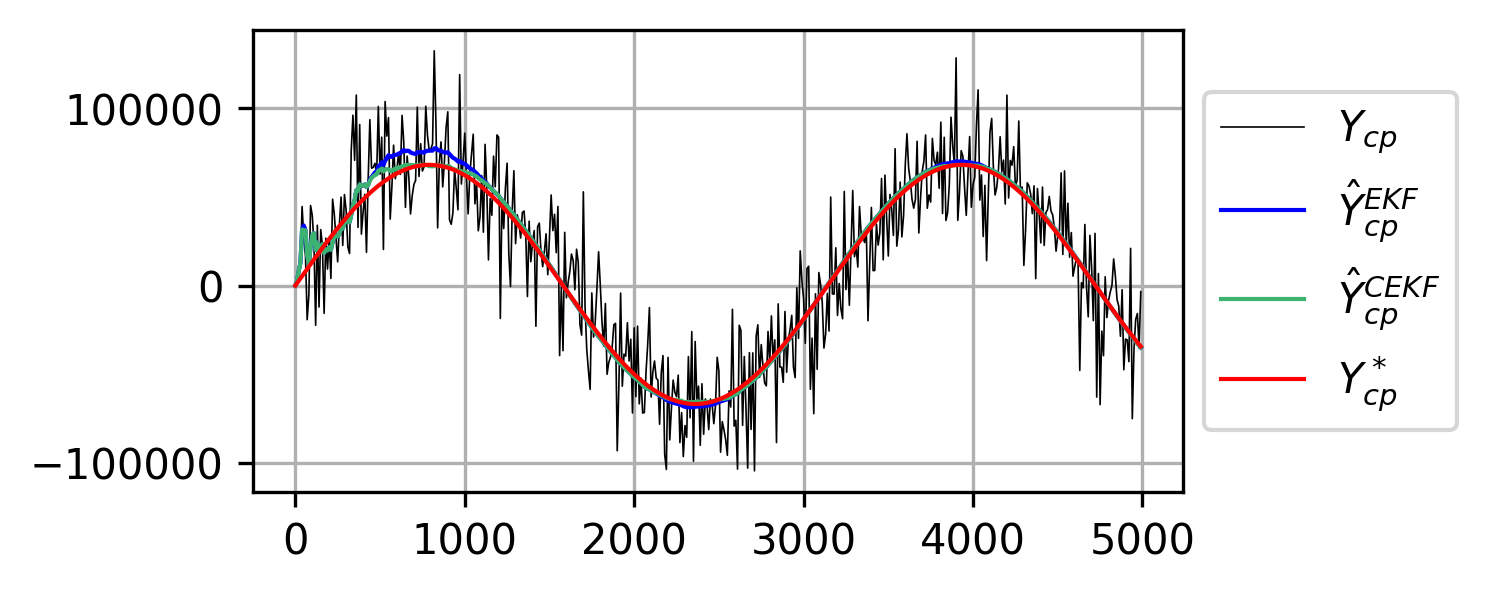

sigma_y =  0.423
sigma_y_CEKF =  0.423
sigma_theta =  0.136
theta_mean =  1.083


In [ ]:
# Michael Kolesov
# NSTU
# Contact email: artekovec@outlook.com

import sys
from scipy.optimize import minimize
import numpy as np
import math as mth
import matplotlib.pyplot as plt

dt = 10  # Δt
N = 500  # number of observations

f = lambda x, t: np.array([x[0] + x[4] * t * mth.cos(x[2]),  # f и df - UAV model description
                           x[1] + x[4] * t * mth.sin(x[2]),
                           x[2] + x[3] * t,
                           x[3],
                           x[4]])
df = lambda x, t: np.array([[1, 0, 0, 0, t * mth.cos(x[2])],
                            [0, 1, 0, 0, t * mth.sin(x[2])],
                            [0, 0, 1, t, 0],
                            [0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 1]])

h = lambda x: np.array([x[0]])  # Jacobian
dh = lambda x: np.array([[1, 0, 0, 0, 0]])  # dh/dx (t(k+1)|t(k))
x_0 = np.array([0, 0, 0, 0.002, 27])  # initial value x_0
P_0 = np.array([[10, 0, 0, 0, 0],
                [0, 10, 0, 0, 0],
                [0, 0, 10, 0, 0],
                [0, 0, 0, 10000, 0],
                [0, 0, 0, 0, 10000]])  # initial value P_0

G = np.array([0, 0, 0, 0.01, 0.03])  # noise vector
Q = 2 * 10 ** -10
R = np.matrix([[10000]])  # covariance matrix R


def create_noise(G, Q):  # noise generation
    noise = np.empty(len(G))
    for i in range(len(G)):
        val = np.random.normal(0, Q)
        noise[i] = G[i] * val
    return noise


def matrix_to_array(z):
    l = np.empty(len(z))
    for i in range(len(z)):
        l[i] = float(z[i][0])
    return l


def generate_data():  # testing data generation
    time = np.empty(N)
    trueDataArray = np.empty(N)
    trueDataArray[0] = h(x_0)
    y = np.empty(N)
    time[0] = 0
    y[0] = h(x_0)
    x_i = x_0
    x_true = x_0

    for i in range(1, N):
        time[i] = dt * i

        noise = create_noise(G, Q)
        x_k_1 = np.array(f(x_i, dt)) + noise  # system noise
        y[i] = h(np.array(f(x_i, dt))) + np.random.normal(0, R)  # sensor noise
        x_i = x_k_1

        x_buf = np.array(f(x_true, dt))
        trueDataArray[i] = h(np.array(f(x_true, dt)))
        x_true = x_buf
    return y, trueDataArray, time


def plot_data(time, y, EKF_res, CEKF_res, trueData):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=300)
    fig.canvas.manager.set_window_title('Results of parameter identification')
    plt.grid()
    plt.plot(time, y, 'k', label='$Y_{ср}$', linewidth=0.4)  # measurement data with noise
    plt.plot(time, EKF_res, 'b', label='$\^Y_{ср}^{EKF}$', linewidth=1)  # measurement data after EKF
    plt.plot(time, CEKF_res, 'mediumseagreen', label='$\^Y_{ср}^{CEKF}$',
             linewidth=1)  # measurement data after CEKF
    plt.plot(time, trueData, 'r', label='$Y_{ср}^*$', linewidth=1)  # true data
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def predict(func, dfunc, t, x_k, P_k, G_k=np.matrix([[0]]), Q_k=np.matrix([[0]])):  # one-step prediction
    x_k_1 = func(x_k, t)
    P_k_1 = dfunc(x_k, t).dot(P_k).dot(dfunc(x_k, t).T) + (G_k * Q_k).dot(G_k.T)
    return x_k_1, P_k_1


def update(x_k, z_k_1, h, P_k, dH, R_k_1=np.matrix([[0]])):  # updating (filtering)
    eps = z_k_1 - dH(x_k) * x_k
    B = dH(x_k).dot(P_k).dot(dH(x_k).T) + R_k_1
    Kk_1 = P_k.dot(dH(x_k).T) * np.linalg.inv(B)
    P_k_1 = (np.diag(np.ones(len(x_k))) - Kk_1 * dH(x_k)) * P_k
    x_k_1 = x_k.T + (Kk_1 * (z_k_1 - h(x_k))).T
    return matrix_to_array(x_k_1.T), P_k_1, np.linalg.norm(Kk_1), B, eps


def kalman_filter(f_theta, df_theta, y, h, dh):  # Kalman filtering (EKF/CEKF)
    filtered_with_EKF = np.zeros((N, 5))
    filtered_with_EKF[0] = x_0
    filtered_with_CEKF = np.zeros((N, 5))
    filtered_with_CEKF[0] = x_0

    x = x_0
    P = P_0

    kalman_gain = np.empty(N)  # Kalman Gain
    kalman_gain[0] = mth.inf
    F = np.array([1, 0, 0, 0, 0])  # Fx = b - constraint for CEKF
    constraint_value = 13700  # constraint value
    optimization_sum = 0

    for i in range(1, N):
        x_k, P_k = predict(f_theta, df_theta, dt, x, P, G, Q)  # prediction step
        x_1, P_1, kalman_gain[i], B_t, eps_t = update(x_k, y[i], h, P_k, dh, R)  # updating

        # accumulate the sum to calculate the identification criterion
        optimization_sum += mth.log(np.linalg.det(B_t)) + matrix_to_array(
            (eps_t * (matrix_to_array(np.linalg.inv(B_t)))).dot(eps_t.T))

        x = x_1
        P = P_1
        filtered_with_EKF[i] = x_1
        filtered_with_CEKF[i] = x_1
        if mth.fabs(h(x_1)) > constraint_value:  # If the restriction conditions are not met, then CEKF is activated.
            if h(x_1) > 0:
                J = matrix_to_array(P_1.dot(F.T).T) * matrix_to_array(np.linalg.inv(dh(x_1).dot(P_1).dot(F.T)))
                x_CEKF = x_1 + J * (constraint_value - F.dot(x_1.T))
                P_cekf = (np.diag(np.ones(len(x_1))) - J.dot(F)).dot(P_1)
            elif h(x_1) < 0:
                J = matrix_to_array(P_1.dot(F.T).T) * matrix_to_array(np.linalg.inv(dh(x_1).dot(P_1).dot(F.T)))
                x_CEKF = x_1 + J * (-constraint_value - F.dot(x_1.T))
                P_cekf = (np.diag(np.ones(len(x_1))) - J.dot(F)).dot(P_1)
            filtered_with_CEKF[i] = x_CEKF

    EKF = [h(x) for x in filtered_with_EKF]

    CEKF = [h(x) for x in filtered_with_CEKF]

    return EKF, CEKF, optimization_sum


def parametrize(theta):  # parameterization by the found THETA value
    f_theta = lambda x, t: np.array([x[0] + x[4] * t * theta[0] * mth.cos(x[2]),
                                     x[1] + x[4] * t * mth.sin(x[2]),
                                     x[2] + x[3] * t,
                                     x[3],
                                     x[4]])
    df_theta = lambda x, t: np.array([[1, 0, 0, 0, t * theta[0] * mth.cos(x[2])],
                                      [0, 1, 0, 0, t * mth.sin(x[2])],
                                      [0, 0, 1, t, 0],
                                      [0, 0, 0, 1, 0],
                                      [0, 0, 0, 0, 1]])
    return f_theta, df_theta


def identification_criterion(theta, y_noise):  # Minimized function/calculation of the identification criterion
    f_min = 0

    m = 1
    f_theta, df_theta = parametrize(theta)
    filtr_f, filtr_fCEKF, chi_sum = kalman_filter(f_theta, df_theta, y_noise, h, dh)
    f_min += chi_sum
    f_min += (mth.log(2 * mth.pi) * N * m)
    f_min = f_min / 2

    # np.savetxt('data_EKF_1.txt', filtr_f)
    # np.savetxt('data_CEKF_1.txt', filtr_fCEKF)
    return f_min


def main():
    # Generation and loading of measurement data
    # y_noise, y_true, y_time = generate_data()
    # np.savetxt('data_noise_1.txt', y_noise)
    # np.savetxt('data_true_1.txt', y_true)
    # np.savetxt('y_time.txt', y_time)

    # Application of the Kalman filter/ Parameter estimation
    # theta = float(sys.argv[4])
    # theta = np.array([0.9])
    # res = minimize(identification_criterion, theta, args=y_noise, method='Powell',
    #                bounds=[[0, 2]])  # идентификация параметров
    # print(res.x)
    # with open("thetas.txt", "a+") as file_theta:  # сохранение результата оценивания в файл
    #     np.savetxt(file_theta, res.x)

    # Calculation of theta_mean, sigma_y, sigma_theta

    y_noise = np.empty((5, 500))

    y_noise[0] = np.loadtxt('data_noise_1.txt')
    y_noise[1] = np.loadtxt('data_noise_2.txt')
    y_noise[2] = np.loadtxt('data_noise_3.txt')
    y_noise[3] = np.loadtxt('data_noise_4.txt')
    y_noise[4] = np.loadtxt('data_noise_5.txt')

    data_with_noise = np.zeros(N)
    for i in range(5):  # вычисление Y_ср
        data_with_noise += y_noise[i]

    y_EKF = np.empty((5, 500))
    y_EKF[0] = np.loadtxt('data_EKF_1.txt')
    y_EKF[1] = np.loadtxt('data_EKF_2.txt')
    y_EKF[2] = np.loadtxt('data_EKF_3.txt')
    y_EKF[3] = np.loadtxt('data_EKF_4.txt')
    y_EKF[4] = np.loadtxt('data_EKF_5.txt')

    filtered_data_EKF = np.zeros(N)
    for i in range(5):  # вычисление Y_ср(EKF)
        filtered_data_EKF += y_EKF[i]

    y_CEKF = np.empty((5, 500))
    y_CEKF[0] = np.loadtxt('data_CEKF_1.txt')
    y_CEKF[1] = np.loadtxt('data_CEKF_2.txt')
    y_CEKF[2] = np.loadtxt('data_CEKF_3.txt')
    y_CEKF[3] = np.loadtxt('data_CEKF_4.txt')
    y_CEKF[4] = np.loadtxt('data_CEKF_5.txt')

    filtered_data_CEKF = np.zeros(N)
    for i in range(5):  # вычисление Y_ср(CEKF)
        filtered_data_CEKF += y_CEKF[i]

    y_true = np.empty((5, 500))
    y_true[0] = np.loadtxt('data_true_1.txt')
    y_true[1] = np.loadtxt('data_true_2.txt')
    y_true[2] = np.loadtxt('data_true_3.txt')
    y_true[3] = np.loadtxt('data_true_4.txt')
    y_true[4] = np.loadtxt('data_true_5.txt')

    true_data = np.zeros(N)
    for i in range(5):  # загрузка истинных значений Y_ср
        true_data += y_true[i]

    y_time = np.loadtxt('y_time.txt')

    plot_data(y_time, data_with_noise, filtered_data_EKF, filtered_data_CEKF, true_data)  # вывод графиков

    plt.show()
    sigma_y = np.linalg.norm(data_with_noise - filtered_data_EKF) / np.linalg.norm(
        data_with_noise)  # вычисление sigma_y для EKF
    print('sigma_y = ', round(sigma_y, 3))

    sigma_y_CEKF = np.linalg.norm(data_with_noise - filtered_data_CEKF) / np.linalg.norm(
        data_with_noise)  # вычисление sigma_y для CEKF
    print('sigma_y_CEKF = ', round(sigma_y_CEKF, 3))

    theta_ist = np.array([1, 1, 1, 1, 1])
    theta_sum = np.loadtxt('thetas.txt')

    sigma_theta = np.linalg.norm(theta_ist - theta_sum) / np.linalg.norm(theta_ist)  # вычисление sigma_theta
    print('sigma_theta = ', round(sigma_theta, 3))
    print('theta_mean = ', round(np.sum(theta_sum) / 5, 3))  # вычисление theta_mean


if __name__ == '__main__':
    main()
